In [1]:
import math
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
from torch.autograd import Variable 
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

X shape:  (1140, 2914)
y shape:  (1140,)
target_names:  ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


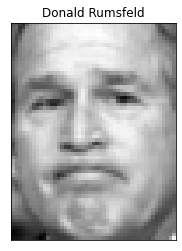

(array([0, 1, 2, 3, 4]), array([175,  85, 408,  78, 109]))
(array([0, 1, 2, 3, 4]), array([ 61,  36, 122,  31,  35]))


In [57]:
# Load data
lfw_dataset = fetch_lfw_people(min_faces_per_person=100)
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
n_samples, h, w = lfw_dataset.images.shape
print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("target_names: ", target_names)
plt.imshow(X[0].reshape((h, w)), cmap=plt.cm.gray)
plt.title(target_names[1], size=12)
plt.xticks(())
plt.yticks(())
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# count unique values of y_train
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

# 1. What is a neural network? 

### 1.1 Intuitive Understanding of Neural Networks
* NN is analogous to the neural system of brains (**neural diagram** can be seen in the left of the figure below)
    + Brains rely on >100 billions neurons
    + Why is the model of brains so important for intelligence?  1) communicate with each other via synapses. Each neuron can rececive up to 10K connections from/to other neurons; 2) "Hundreds of different organs, [each carry out their own specific functions](https://human-memory.net/occipital-brain-lobe/)".  
    * Activation process: the process by which a neuron becomes active through connections with other neurons, which then stimulates (triggers the activation of) other connected neurons. 
    + How to represent the neurons, their connections (synapses) and functional organs mathematically?
    <!-- input/intermediate output values; Weights or paramters     -->
    <!-- Each layer consists of **input/intermediate/output values (vertices/nodes/neurons)** connected by **weights** (synapses).  -->
    + How does the activation process of a neural network stimulate different functions?
    <!-- forward pass contains different activation functoins and architectures -->

### 1.2 Mathematicaly, as shown on the right of the above image,

<center><img src="https://i.loli.net/2021/08/12/7yaGWTIKlHNz6mD.png" width='500' ></center>

* What are the differences between linear regression, logistic regression and neural network?
    + Logistic regression has no intermediate layer, while NN has multiple intermediate layers, each with multiple neurons. 
    + i.e., a multivirate function with multiple inputs and one output vs a chain of multivariate functions with multiple inputs and multiple outputs
    
* Linear Layer: a linear transformation/function
    + Notation: Let  $m$ = the number of examples, $n_i$ = the input dimension, $n_o$ = the output dimension
    + The linear function:  map input $X$ to the output $y$ by finding the parameters $W$ (determined by loss function): 
    +  $\hat{y} = W \cdot X$  where $\mathbf{X} \in \mathbb{R}^{n_i \times m}$ and $\mathbf{W} \in \mathbb{R}^{n_o \times n_i}$ and $\mathbf{\hat{Y}} \in \mathbb{R}^{n_o \times m}$
<!--  +  The form conforms to the implementation in Tensorflow： $\hat{y} = X \cdot W$  where $\mathbf{X} \in \mathbb{R}^{m \times n_i}$ and $\mathbf{W} \in \mathbb{R}^{n_i \times n_o}$ and $\mathbf{\hat{Y}} \in \mathbb{R}^{m \times n_o}$ 

    + Example of three neurons in a 2x3 linear layer where $n_i=2$ and $n_o=3$
$$\text{Neuron}_1 = 2 x_{1}- x_{2}$$
$$\text{Neuron}_2 = -x_{1} + 2x_{2}$$
$$\text{Neuron}_3 = 5x_{1} + 0.5x_{2}$$
The output of this layer can be efficiectly calculated via **matrix-vector product**:
$$
\left[\begin{array}{rr}
2 & -1 \\
-1 & 2 \\
5  & 0.5
\end{array}\right]\left[\begin{array}{l}
x_1 \\
x_2 
\end{array}\right]
$$
    + All the connections between two adjacent layers is encoded in the matrix $W=\left[\begin{array}{rr}
2 & -1 \\
-1 & 2 \\
5  & 0.5
\end{array}\right]$, which should be learned from training data.
    + we can efficiently calculate the values for $m$ examples via matrix multipication
    $$
    \left[\begin{array}{rr}
    2 & -1 \\
    -1 & 2 \\
    5  & 0.5
    \end{array}\right]\left[\begin{array}{l}
    x_1^1 & x_1^2& ... & x_1^m\\
    x_2^1 & x_2^2& ... & x_2^m
    \end{array}\right]
    $$
    
    
    

<!--     + If a bias term $b\in \mathbb{R}^{n_o \times 1}$ is added: $\hat{y} = W \cdot X + b$. But no need to do that since (1) $W$ do the job of transforming input or $b$ could be considered as  $w_{n+1} \dot x$ where $x=1$.
    + Although the first notation makes more sense for me to imagine it as the transformation in the high-dimension space, the second notation is commonly used for implementation. Here I change (use $\theta$ and transpose) the second notation into $\theta^{T} X$. Because $\theta$ which can avoid confusion for NLP notations and unify weights and bias.
    + Anyway, the linear node and bias nodes would not be shown in neural network diagrams since every neuron is assumed to have a linear node along with its corresponding bias. But we just use its output denoted as $z$ where $z = \theta^{T} X$ -->

<!-- * Function v.s. Equation: 
    + each equation represents a line in two dimensional space (or a plane) 
    + each function is an affine transformation (linear transformation with bias) which transform the whole plane e.g., $\text{hidden_neuron_1} = 2 w_{1}- w_{2}$

$$2 x_{1}- x_{2}=0$$
$$-x_{1} + 2x_{2}=3$$
This can be also represented in the matrix form to be solved efficiently.
$$
\left[\begin{array}{rr}
2 & -1 \\
-1 & 2
\end{array}\right]\left[\begin{array}{l}
x_1 \\
x_2 
\end{array}\right]=\left[\begin{array}{l}
0 \\
3
\end{array}\right]
$$ -->

In [7]:
# matrix-vector product
n_i = X_train.shape[1]
n_m = 256
n_o = 1

# n_i neurons in the input/1st layer
x = X_train[0]

# activate n_m neurons in the 2nd layer
W1 = np.random.uniform(-1/np.sqrt(n_i), 1/np.sqrt(n_i), (n_m, n_i))
A1 = np.dot(W1, x)

# activate n_o neuron in the output layer
W2 = np.random.uniform(-1/np.sqrt(n_m), 1/np.sqrt(n_m), (n_o, n_m))
A2 = np.dot(W1, x)
A2.shape

(256,)

## 2. Activation functions
Add non-linearity into the neural network
* Sigmoid
    
    $$p =\frac{1}{1+e^{-x}}$$
    + Note that the sigmoid function is also used for calculating probability in the last layer for computing the loss
* tanh
    $$p=\frac{2}{1+e^{-2 x}}-1$$

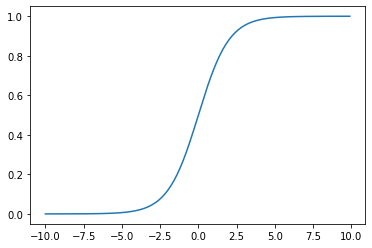

In [13]:
# Sigmoid Function
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

# plot
z = np.arange(-10, 10, 0.1)
s = sigmoid(z)
plt.plot(z, s)
plt.show()


In [22]:
# activate n_m neurons in the 2nd layer
W1 = np.random.uniform(-1/np.sqrt(n_i), 1/np.sqrt(n_i), (n_m, n_i))
A1 = np.tanh(np.dot(W1, x))

# activate n_o neuron in the output layer
W2 = np.random.uniform(-1/np.sqrt(n_m), 1/np.sqrt(n_m), (n_o, n_m))
y_prod = sigmoid(np.dot(W2, A1))
y_prod

NameError: name 'sigmoid' is not defined

## 3. More complication architectures for data transformation： convolution (CNN), recurrent (RNN), Transformer

* Real-world data often contains properties that are sequential or spatial in nature, such as text, audio, video, sensor readings, and images. These properties can be important in determining the meaning of the data, and therefore need to be taken into account when processing the data.

* Sequential properties refer to the fact that the positions of data points matter in explaining the overall meaning of the data, while spatial properties refer to the fact that the relative positions of data points matter in determining the meaning of the data. 
* Communication using language: we use a sequence of words to express our thoughts and ideas. 
    + The order in which we arrange these words is very important: "The cat sat on the mat." v.s. "The mat sat on the cat."
    + In order to accurately predict or classify language data, a neural network must be able to understand the relationships between words in a sentence and how they are ordered. Hence, sequential neural network architectures are designed to take into account the sequential nature of language data and can effectively learn the complex relationships between words in a sentence.

<!-- * (Optional) The way I think of why we need different transformations in neural net: Just like playing Lego we need more than regular pieces🔺 to build real-world things 🚉, 📱... , neural network consist of more than linear transformation to model the real-world problem. This depends on prior knowledge of what problem you want to solve.  For example,  
if you build ⏰, you need irregularly shaped pieces like wheel🏽⚙️. 
If you predict the increase of human population in China next year, you may use exponential function since you know  it will increase exponentially by time. 
If you predict image class, you will use convolution transformation since yoou know image has to be understood by its combination of pixels rather than each pixel separately. -->

<p style="color:red">I comment some codes for implementing different architectures here.</p>
<!-- ### 3.1 RNN

More details see [RNN/LSTM](https://www.kaggle.com/sergioli212/rnn-lstm-from-scratch/)

Code:
# input data with middle dimention 10 represents sequence length
X = torch.Tensor(np.random.randn(10, 3, 4))
n_x, m, T_x = X.shape # 3, 10, 4
n_y, n_a = 2, 5 

# pytorch linear API + tanh activation function
linear_xa = torch.nn.Linear(n_x, n_a)
linear_aa = torch.nn.Linear(n_a, n_a)
a_prev = torch.randn(m, n_a)
for t in range(T_x):
    input1 = linear_xa(X[:,:,t])
    input2 = linear_aa(a_prev)
    a_prev = torch.tanh(input1+input2)
# print(a_prev.shape)


### 3.2 CNN

# code
# keras
# tf.keras.layers.Conv1D(
#     filters,
#     kernel_size,
#     strides=1,
#     padding="valid",
#     data_format="channels_last",
#     dilation_rate=1,
#     groups=1,
#     activation=None,
#     use_bias=True,
#     kernel_initializer="glorot_uniform",
#     bias_initializer="zeros",
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     **kwargs
# )
# The inputs are 128-length vectors with 10 timesteps, and the batch size is 4.  
input_shape = (4, 10, 128)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x)
print(y.shape)

# pytorch: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html#torch.nn.Conv1d
# torch.nn.Conv1d(
#     in_channels,  # unlike keras, pytorch cannot infer the input channels since it has no placeholder for input
                    # put sequence length here
#     out_channels, 
#     kernel_size, 
#     stride=1,
#     padding=0, 
#     dilation=1, 
#     groups=1, 
#     bias=True, 
#     padding_mode='zeros')
x = tf.constant(
[[[1.,2.,3.],
  [2.,2.,1.],
  [3.,2.,6.]],

 [[4.,4.,5.],
  [5.,5.,5.],
  [6.,6.,7.,],],

 [[7.,8.,8.,],
  [8.,6.,7.,],
  [9.,8.,8.,]]] , dtype='float32')
print(x)

# keras API
max_pool_1d = tf.keras.layers.GlobalMaxPooling1D()
# max_pool_1d = tf.keras.layers.MaxPooling1D(3)
print(max_pool_1d(x))

# jax API
from jax import random
import jax.numpy as jnp
key = random.PRNGKey(1701)
x = jnp.linspace(0, 10, 500)
y = jnp.sin(x) + 0.2 * random.normal(key, shape=(500,))
window = jnp.ones(10) / 10
y_smooth = jnp.convolve(y, window, mode='same')
plt.plot(x, y, 'lightgray')
plt.plot(x, y_smooth, 'black'); -->


## 4. How to Acquire A Set of Weights Optimized for the Data/Task?
1. Randomly initialized weights
2. Define loss function. During optimization, it can can be used as an minimization objective function for weight optimization.
3. Iteratively update weights to minimize the loss function using gradient descent

### 4.1 [Loss function](https://www.kaggle.com/sergioli212/cross-entropy-loss-details).
* Intuitively, it is used to quantify, given empirical data (i.e., training samples), how wrong the current model predicts in contrast to the true values of samples. The quantity is called the loss between model outputs and grouth truth.
* Let's design loss function for classification and regression problems?
  
* The formal definition relates to **Bayes Theorem** for machine learning in Week 2 and **Minimizing Negative Log Likelhood** in Week 6
    + Bayes Theorem: maximize Pr(parameters|data) $\propto$ Pr(data|parameters) * Pr(parameters)
    + Likelihood: $ L(\theta) =  Pr((X, y)|\theta) $
    + Given a set of $\theta$, the likelihood can be calculated by "the product of the probabilities for each data point". The likelihood measures whether a given $\theta$ is a good estimation. 
$ L(\theta) =  Pr((X, y)|\theta)= \prod_{i=1}^{N} Pr\left(y^{(i)}, x^{(i)} | \theta\right) =Pr\left(y^{(i)} | x^{(i)} , \theta\right)$
    + Why does it call likelihood not probability? ⚠️ although we fix $\theta$ to caluculate the probability $Pr(X, y | \theta)$, we never know the only true $\theta$ to calculate the true 👉$Pr(X, y | \theta)$. The probability is really just fake. That's why we give it a new name --- `LIKELIHOOD`. 
<!--     We normally use Negative Log Likelhood (NLL). -->
    + The optimal $\theta$ should give the maximum liklihood or the minimum NLL $\rightarrow$ We try our best to find a set of $\theta$ which leads to NLL as low as possible, i.e., $ \theta = argmax L(\theta)=Pr(y | X , \theta)$. 



MLE for Binary Classification
* The last layer normaly has one neuron/probability from the sigmoid function, denoted as
 $ p=Pr(y = 1|x; \theta)  $
 $$\begin{aligned} NLL = -\log L(\theta) \\ &=-\sum_{i=1}^{m} y^{(i)} \log p+(1-y^{(i)}) \log (1-p)) \end{aligned}$$

* It can be considered as **KL-devergence**, which measures the similarity between two distributions. [This post](https://jaketae.github.io/study/kl-mle/) proves that "minimizing the KL divergence amounts to finding the maximum likelihood estimate of $\theta$". During the supervised learning，the ground-truth distribution is know. Hence, minizing **cross entropy** equals to the minimization of KL-devergence
$$D_{\mathrm{KL}}(Y \| \hat{Y})=-\sum_{i} y^{(\mathrm{i})} \log \frac{\hat{y}^{(\mathrm{i})}}{y^{(\mathrm{i})}}$$ 

In [44]:
y_true = np.array([1])
log_probs = np.multiply(y_true ,np.log(y_prod)) + np.multiply((1-y_true), np.log(1-y_prod))
cost = (-1/len(y_true)) * np.sum(log_probs)
print(cost)

0.6597159476847235


MLE for Multiclass Classification
* Softmax Funtion: Except for sigmoid function, softmax function is used to calculate the output probability distribution for more than two classes
    $$p_i =\frac{e^x_i}{\sum_{i=1}^{K} e^{x_i}} $$

In [71]:
def softmax(z):
    e_z = np.exp(z)
    return e_z / np.sum(e_z, axis=-1).reshape(-1, 1)

logits = [[4.0, 2.0, 1.0], 
          [0.0, 5.0, 1.0]]


y_prob = softmax(logits)
y_prob

array([[0.84379473, 0.1141952 , 0.04201007],
       [0.00657326, 0.97555875, 0.01786798]])

In [70]:
# one-hot representations
labels = np.array([[1],[2]])

# L(y_pred, y) = -sum(y * log y_pred for each class) = -log y_pred[true_class_idx]
total_loss = -np.log(np.take_along_axis(y_prob, labels, axis=-1))
np.mean(total_loss)

# pytorch API
loss = F.nll_loss(torch.from_numpy(np.log(y_prob)), labels))
print(loss)
# loss = F.cross_entropy(torch.tensor(logits), torch.tensor([1, 2]))

# Tensorflow API
# tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)


tensor(3.0973, dtype=torch.float64)
tensor(3.0973)


### 4.2. Optimization algorithm: [Gradient Descent](https://medium.com/@sergioli/understanding-gradient-descent-in-pytorch-dca50926bce4)
* Use gradients to update weights
* [Survey Paper from Sebastian Ruder](https://arxiv.org/abs/1609.04747)

Calculating gradient via so-called backward propagation
* The `Tensor` class is the finest class we can trace the parameters and their corresponding gradients during backward propagation
* The attribute `requires_grad` to control whether the gradients should be calculated during the backward. Specifically, after performing operations (e.g., sin) on the input tensor during forward propagation, the `grad_fn` attribute would be added into the output tensor in order to calculate gradients afterward.




* Recording Tensor Operations: Computational Graph
[The official introduction](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#computational-graph) 
<!-- 
> Conceptually, autograd keeps a record of data (tensors) & all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[`Function`](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.
>
> ![image.png](attachment:5e01a2e2-7506-448a-8e32-71531c5f6f12.png)![image.png](attachment:235839b6-fb87-45b4-a999-19d08bc69415.png)
>
> In a forward pass, autograd does two things simultaneously:
> 
> - run the requested operation to compute a resulting tensor, and
> - maintain the operation’s *gradient function* in the DAG.
>
> The backward pass kicks off when ``.backward()`` is called on the DAG
root. ``autograd`` then:
> 
> - computes the gradients from each ``.grad_fn``,
> - accumulates them in the respective tensor’s ``.grad`` attribute, and
> - using the chain rule, propagates all the way to the leaf tensors.
> 
> Below is a visual representation of the DAG in our example. In the graph,
the arrows are in the direction of the forward pass. The nodes represent the backward functions
of each operation in the forward pass. The leaf nodes in blue represent our leaf tensors ``a`` and ``b``.
> 
> .. figure:: /_static/img/dag_autograd.png
> 
> <div class="alert alert-info"><h4>Note</h4><p>**DAGs are dynamic in PyTorch**
  An important thing to note is that the graph is recreated from scratch; after each
  ``.backward()`` call, autograd starts populating a new graph. This is
  exactly what allows you to use control flow statements in your model;
  you can change the shape, size and operations at every iteration if
  needed.</p></div>
> 
> Exclusion from the DAG
>
> ``torch.autograd`` tracks operations on all tensors which have their
``requires_grad`` flag set to ``True``. For tensors that don’t require
gradients, setting this attribute to ``False`` excludes it from the
gradient computation DAG.
>
> The output tensor of an operation will require gradients even if only a
single input tensor has ``requires_grad=True``. -->

In [16]:
torch.from_numpy(X_batch.T)

tensor([[ 93.3333,  43.6667, 113.3333,  ...,  60.3333,  41.6667,  82.6667],
        [106.0000,  41.0000, 132.6667,  ...,  79.6667,  41.0000,  83.6667],
        [118.0000,  38.0000, 143.6667,  ...,  96.6667,  51.3333,  81.3333],
        ...,
        [170.3333, 142.3333, 254.0000,  ..., 147.0000, 211.6667,  52.6667],
        [166.3333, 145.0000, 253.6667,  ..., 156.6667, 209.0000,  24.0000],
        [163.6667, 112.0000, 253.6667,  ..., 166.3333, 204.3333,  24.3333]])

In [59]:
# create an input tensor
X_batch = X_train[:2]
y_batch = y_train[:2]
X_batch = torch.from_numpy(X_batch.T).float()
y_batch = torch.from_numpy(y_batch)




In [60]:
W1 = np.random.uniform(-1/np.sqrt(n_i), 1/np.sqrt(n_i), (n_m, n_i))
W1 = torch.from_numpy(W1).float()
W1.requires_grad=True
A1= torch.matmul(W1, X_batch)
A1 = F.tanh(A1)

W2 = np.random.uniform(-1/np.sqrt(n_m), 1/np.sqrt(n_m), (5, n_m))
W2 =  torch.from_numpy(W2).float()
W2.requires_grad=True
A2= torch.matmul(W2, A1)
y_prob = F.softmax(A2.T)

# input tensor has no grad_fn
# print(X_batch.grad_fn)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [61]:
y_batch

tensor([2, 3])

In [62]:
loss = F.nll_loss(torch.log(y_prob), y_batch)


In [64]:
loss.backward()

In [65]:
W1

tensor([[ 0.0134, -0.0008,  0.0145,  ..., -0.0002,  0.0173,  0.0156],
        [-0.0101, -0.0005, -0.0152,  ...,  0.0072,  0.0075,  0.0012],
        [-0.0043,  0.0013, -0.0150,  ...,  0.0117, -0.0130, -0.0144],
        ...,
        [-0.0001,  0.0130,  0.0130,  ...,  0.0055, -0.0174, -0.0105],
        [ 0.0017,  0.0101, -0.0002,  ...,  0.0109, -0.0180,  0.0169],
        [ 0.0055, -0.0080, -0.0150,  ...,  0.0163,  0.0152,  0.0036]],
       requires_grad=True)

How a batch of samples （e.g., [x1, x2]） accumulate gradients? 

In [ ]:
# parameters
w = torch.Tensor([1.,2.,3.])
print('Original w grad:', w.grad)


# we create `x` containing two examples, each has 3-dimensional features
x1 = torch.Tensor([1., 2., 3.])
x2 = torch.Tensor([4., 5., 6.])

y = x1 * w
z = y.sum()
z.backward()
print('w grad with x1:', w.grad)

y = x2 * w
z = y.sum()
w.grad = None
z.backward()
print('w grad with x2:', w.grad)


# The gradients will be summed up in the batch dimension
x = torch.Tensor([[1., 2., 3.],
                  [4., 5., 6.]])
y = x * w
z = y.sum()
w.grad = None
z.backward()
print('mini-batch gradient of parameters with x1 and x2:', w.grad)

## 5. Deep Learning Frameworks
* The common transformations can be divided into two categories: 
    + functions (no parameters during learning process):`pytorch.functional` contains the basic functions for high-level object-oriented modules with `torch.Tensor` (matrices) as parameters
    + architectures (containing learnable parameters): Rather than build neural network in a neuron/connection level, deep learning frameworks build NN in the **layer** level and use Object-oriented Implementations of Architectures. Two popular ones are Tensorflow `tensorflow.keras.layers` (e.g., `Conv1D`) and Pytorch `torch.nn.Module` (e.g., `Linear`, `Conv1d`, `Dropout`).
    + Pros/Cons of using layer-level architectures: only need to care inputs/outputs of each layers; unknown design decision
    + How to trace the parameters ?


<!-- Combination of Layers/Architectures
* how model parameters are used by `torch.nn.Module`?
* how they **nest** different layers or operations?
* How does backward propagation work in pytorch `AutoGrad`? -->

In [2]:
# # sklearn
# mlp = MLPClassifier(hidden_layer_sizes=(256,), \
#                     activation="relu", \
#                     solver='adam',\
#                     beta_1=0.9, beta_2=0.999, \
#                     learning_rate='constant', learning_rate_init=0.001, \
#                     max_iter=1000, random_state=0)
# for i in range(mlp.n_layers_)[:-1]:
#     print(i+1, '-th layer: ', mlp.coefs_[i].shape)
# mlp.fit(X_train, y_train)
# plt.plot(mlp.loss_curve_)
# plt.show()
# y_pred = mlp.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred, target_names=target_names))

In [14]:
# Create model
torch.manual_seed(0)
class MLP(torch.nn.Module):
    # a MLP model with 16 hidden layers
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        # 16 hidden layers
        for i in range(16):
            setattr(self, 'fc'+str(i), torch.nn.Linear(input_size, hidden_size))
            input_size = hidden_size
        self.fc_out = torch.nn.Linear(hidden_size, num_classes)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        out = x
        for i in range(16):
            out = getattr(self, 'fc'+str(i))(out)
            out = self.relu(out)
        out = self.fc_out(out)
        
        return out

# mlp = MLP(h*w, 512, len(target_names))
mlp = torch.nn.Sequential(
    torch.nn.Linear(2914, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 5),
)


In [15]:
# Train model
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# assign the class weights according to the number of samples
# in each class in X
class_weights = [X_train.shape[0]/np.sum(y_train==i) for i in range(len(target_names))]
# class_weights = [1.0, 1.0, 1.0, 1.0, 1.0]
class_weights = torch.tensor(class_weights, dtype=torch.float)


for epoch in range(100):
    optimizer.zero_grad()
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    outputs = mlp(X_train_tensor)
    loss = F.cross_entropy(outputs, y_train_tensor, weight=class_weights)
    loss.backward()
    optimizer.step()
    print('Epoch: ', epoch, ' Loss: ', loss.item())

# Predict
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
y_pred = mlp(X_test_tensor).argmax(dim=1).numpy()

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

Epoch:  0  Loss:  11.462784767150879
Epoch:  1  Loss:  126.77574920654297
Epoch:  2  Loss:  339.53106689453125
Epoch:  3  Loss:  201.82308959960938
Epoch:  4  Loss:  232.55670166015625
Epoch:  5  Loss:  124.06748962402344
Epoch:  6  Loss:  37.500946044921875
Epoch:  7  Loss:  22.166349411010742
Epoch:  8  Loss:  21.941390991210938
Epoch:  9  Loss:  40.41465377807617
Epoch:  10  Loss:  24.672550201416016
Epoch:  11  Loss:  34.74315643310547
Epoch:  12  Loss:  20.248130798339844
Epoch:  13  Loss:  18.979869842529297
Epoch:  14  Loss:  17.249162673950195
Epoch:  15  Loss:  18.310232162475586
Epoch:  16  Loss:  10.818763732910156
Epoch:  17  Loss:  12.157012939453125
Epoch:  18  Loss:  10.717308044433594
Epoch:  19  Loss:  11.436904907226562
Epoch:  20  Loss:  8.422748565673828
Epoch:  21  Loss:  6.02554178237915
Epoch:  22  Loss:  8.937173843383789
Epoch:  23  Loss:  6.57012414932251
Epoch:  24  Loss:  4.803252220153809
Epoch:  25  Loss:  5.202418327331543
Epoch:  26  Loss:  9.24060535430

## High-level neural network using `nn.Module`

As said above, a neural network is just a stack of operations on data input tensors and model parameter tensors. `nn.Module` has the basic implementation to record the model parameters and operations in high level.

In a nutshell, 

**All the neural networks in Pytorch are built upon the parent class `nn.Module`**

The following code cell demonstrates how model parameters are used by Linear module `class Linear(Module)`.

In [ ]:
# Use Pytorch Linear Module
nn_module = nn.Linear(5, 2)
for p in nn_module.parameters():
    print('W or b: ', p.shape)

`Module` is used **in a nested way**.

In [ ]:
# build customized pytorch nn modules
class Network(nn.Module):
    def __init__(self):
        super().__init__() # pytorch will register layers and operations we put into the network
        
        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x
        
model = Network()
model

## Closing Words 
* A neural network is an universal function approximator. For example, if you use softmax or sigmoid, a neural network represents conditional probability distribution. For understanding this, see [this notebook](https://www.kaggle.com/sergioli212/loss-function-and-optimization).
* the above models/functions are not trained so they are not a model fitting into any data. For understanding this, see [this notebook](https://www.kaggle.com/sergioli212/loss-function-and-optimization).
* Bullshit: The reason I would like to decompose NN architecture and modelling process is because, I think, I always see a lot of implementation packages and tutorials tend to mix up concepts or algorithms as a black box which hurts the flexibility to identify  and adjust finer pieces for solving my problem. For example, to generate adversarial text of NLP, I had a trouble to understand why we could update input instead of model parameters and what is problem of discrete text space and how to add constraints for ensuring fluency fo generating text via loss function (or adversarial objective functions here). All in all, each functions (linear, activation, stacking function, loss functions) during forward pass and their differentiation properties during backward pass should be well understood for deep learning practitioners.

## Reference
* [How to initialize weights?](https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch)